<a href="https://colab.research.google.com/github/Bushman57/Food-Vision101/blob/main/Project_1(FoodVision).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixed Precicion (lecture note)

## Check GPU

Google Colab offers free GPUs (thank you Google), however, not all of them are compatible with mixed precision training.

Google Colab Offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (See here:https://developer.nvidia.com/cuda-gpus)

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA L4 (UUID: GPU-a8c91d78-c219-c34a-363a-0e645e0525ec)


## Get Helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download helper functions script
!cp '/content/drive/MyDrive/Colab Notebooks/Functions.py' /content/

In [ ]:
# Import series of helper functions for the notebook
from Functions import plot_loss_curves,compare_historys # Use weights and biases to monitor the experiments

## Weights and biases

We need to save the metrics and loss of the models and also compare the history


In [ ]:
%%capture
!pip install wandb

In [ ]:
# Weights and biases related import
import wandb
from wandb.integration.keras import WandbMetricsLogger

In [ ]:
# login
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

## Use tensorFlow Datasets to Download data

If you want to get an overview of Tensorflow Dataset (see here:https://www.tensorflow.org/datasets/catalog/overview#all_datasets)

In [ ]:
# Get Tensorflow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list =tfds.list_builders() # get all available datasets in TFDS
print('food101' in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data,test_data), ds_info =tfds.load(name ='food101',
                                           split = ['train','validation'],
                                           shuffle_files = True,
                                           as_supervised =True, # data gets returned in tuple format (data,label)
                                           with_info = True)
## Try using a txt file

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.VLMSHH_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.VLMSHH_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from Tensorflow Datasets

To become one with the data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names =ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor,label)

In [ ]:
# What does one sample of out training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image,label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class names (str form): {class_names[label.numpy()]}
  """)
# Looks like our labels are not one-hot encoded


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 77
  Class names (str form): pork_chop
  


In [ ]:
# what does our image tensor look like from TFDS's Food101?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [ ]:
# What are the min and max values of image tensor?
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from Tensorflow Datasets

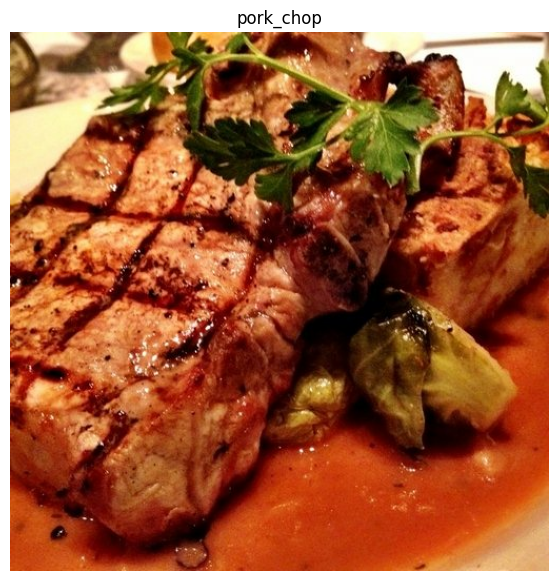

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis('off');

In [ ]:
## Create a function that plots a random image from the TFDS Food101 dataset
def TFDS_plot(train_data,Class_names =class_names):
  load_data =train_data.take(1)
  #Loop through the sample and extract the label and image
  for image,label in load_data:
    image,label
  # Plot the data
  plot_data=plt.imshow(image)
  plot_data=plt.title(Class_names[label.numpy()])
  plot_data =plt.axis('off');
  return plot_data

(-0.5, 511.5, 511.5, -0.5)

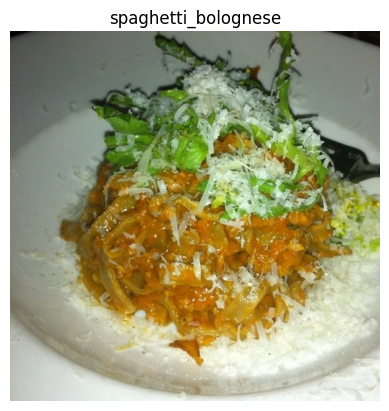

In [ ]:
TFDS_plot(train_data)

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way(e.g. batched,normalized, etc).

However, not all data (including data from TensorFlow datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* it is in `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 and 255)

What do we know models like.
* Data in `float32` dtype (of for mixed precision `float16` and `float32`)
* For batches Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind , we've got  afew things we can tackle with a preprocessing function.

Since we're going to be using EfficientNetBX pretrained model from tf.reras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape  our images to all the same size
2. Convert the dtype of our image tensor from `unit8` to `float32`

In [ ]:
# The reason the function takes in image and labels

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image,label,img_shape=224):
  """
  Converts image datatype from `uint8` -> `float 32` and reshapes
  the image shape and color channels-|
  [img_shape,img_shape,color channel]
  """
  image =tf.image.resize(image,[img_shape,img_shape]) # Reshape target image
  # image =image/255. # scale image value (Depends on the model in use)
  return tf.cast(image,tf.float32), label #return (float32_image, label) tuple


In [ ]:
type(preprocess_img(image,label))

tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image,label)[0]
print(f'Image before prepocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n')
print(f'Image after prepocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n')

Image before prepocessing:
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after prepocessing:
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



# Batch & Prepare datasets

We're going to make our data input pipeline run really fast.

For more resources on this, I'd highlighly recommend [Pipipeline Introduction:](https://www.tensorflow.org/guide/data)



In [ ]:
# Map preprocessing functions to training (and parallelize)
train_data =train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefech it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size =32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data =test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
test_data =test_data.batch(32).prefetch(buffer_size =tf.data.AUTOTUNE) # No need to shuffle


In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

"Hey, Tensorflow, maps this preprocessing function(`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure prepare new batches (prefech) whilst the model is looking through (finding patterns) the current batch"

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
*   TenSorBoard callback to log training results (so we can visualize them later if need be)
*   ModelCheckpoint callback to save our model's progress after feature extraction



In [ ]:
# Create transboard callback (import from our helper function)
from Functions import  create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints_weights/ckpt/checkpoint.weights.h5"
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       monitor='val_accuracy',
                                                       mode = 'max',
                                                       save_best_only=True,
                                                       save_weights_only =True,
                                                       verbose = 0)

# Install and prepare  wandb metrics
import wandb

from wandb.integration.keras import WandbMetricsLogger



## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the tensorflow guide for [mixed precision:](https://www.tensorflow.org/guide/mixed_precision)

🔑 **Note** Ensure you are on a GPU

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') #Set global data to mixed precision

In [ ]:
# mixed_precision.set_global_policy('float32')

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow .keras import layers
from tensorflow.keras import preprocessing

In [ ]:
# Create base_model
input_shape =(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs =layers.Input(shape=input_shape,name = "input_layer")
# Note Efficient models have rescaling built-in for other model without rescaling built-in
# x = preprocessing.Rescaling(1/255.)(x)

x = base_model(inputs, training= False ) # Make sure layers which should be in inference model only stay like that
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)

# To make sure the output tensors are in float 32 for numerical stability
outputs = layers.Activation('softmax',dtype=tf.float32,name='Softmax_layer')(x)
model =tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001)
              )

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 101)               129381    
                                                                 
 Softmax_layer (Activation)  (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (

## Checking layers dtype policies (we are using mixed precision?)



In [ ]:
#check the dtype_pocies attribute of layers in our model
for layer in model.layers:
  print(layer.name,layer.trainable ,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_3 True float32 <Policy "mixed_float16">
dense_3 True float32 <Policy "mixed_float16">
Softmax_layer True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`:Is the layer trainable or not? If `False` the weights are freezed
* `layer.dtype`: the datatype a layer stores its variables in
* `layer.dtype_policy`:the datatype policy a layer computes on its variable with


In [ ]:
# Check the EfficientNetB0 model attributes
for layer in model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <P

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
# You can of course change the global policy to float 32 if not using GPU
# mixed_precision.set_global_policy('float32')

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "float32">

# Project_1(FoodVision) : Fit a model
Fit base model with 3 epochs on the training data and make sure to use create_tensorboard and ModelCheckpoint callback
use weights and biases


In [ ]:
# configs for the weights and biases
configs =dict(
    batch_size =32,
    num_classes =len(class_names),
    shuffle_buffer = 1000,
    image_size = 224,
    image_channels = 3,
    earlystopping_patience =3,
    learning_rate = 1e-3,
    epochs = 3 # to be changed for the different models
)


In [ ]:

# run =wandb.init(
#     project = 'Food101 Vision Project',
#     config =configs
# )

# Using the exact replica of the Transfer learning data
Big_vision_history =model.fit(
    train_data,
    # steps_per_epoch = int((0.5*len(train_data))), # 50% data
    epochs = configs['epochs'],
    validation_data = test_data.repeat(),
    validation_steps= int(0.15*len(test_data)),
    callbacks =[  #WandbMetricsLogger(log_freq =10),
                model_checkpoints ,
                create_tensorboard_callback(dir_name = 'ProjectFood101',
                                                                experiment_name = 'Full_data_feature_extraction')]
)
# run.finish()


Saving TensorBoard log files to: ProjectFood101/Full_data_feature_extraction/20240911-150438
Epoch 1/3
2368/2368 [==============================] - 106s 41ms/step - loss: 1.7177 - accuracy: 0.5827 - val_loss: 1.1280 - val_accuracy: 0.6981
Epoch 2/3
2368/2368 [==============================] - 97s 41ms/step - loss: 1.1987 - accuracy: 0.6891 - val_loss: 1.0338 - val_accuracy: 0.7177
Epoch 3/3
2368/2368 [==============================] - 98s 41ms/step - loss: 1.0540 - accuracy: 0.7242 - val_loss: 0.9907 - val_accuracy: 0.7211


In [ ]:
# Model on the whole test data
model.evaluate(test_data)

790/790 [==============================] - 28s 35ms/step - loss: 0.9807 - accuracy: 0.7340


[0.9806662201881409, 0.7339801788330078]

In [ ]:
# Export model checkpoint to google drive
!cp -r /content/model_checkpoints_weights '/content/drive/MyDrive/Project/Food101 best model'

# Save our model to google colab
model.save('/content/drive/MyDrive/Project/Food101 best model/Project101_Food_Vision.keras')

In [ ]:
# load the weights
Loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Project/Food101 best model/Project101_Food_Vision.keras')

In [ ]:
# Re check the model perfomance on the test data
Loaded_model.evaluate(test_data)

790/790 [==============================] - 30s 35ms/step - loss: 1.0019 - accuracy: 0.7275


[1.0018892288208008, 0.7275247573852539]

In [ ]:
# The model (that are considered the best) can be loaded as -
model2 = tf.keras.models.load_model('/content/model_checkpoints_weights/ckpt/checkpoint.weights.h5')

Model appears to be training well am curious to test the model again but using model checkpoints to save model logins for when the model stops. The model was trained using a TPU


---
### Assignment
* Check on model checkpoints callbacks and try it on the model
* Get a better understanding of using the cache method and other methods that are described in improving the computation of a model try using the mixed precision on the TeslaT4 GPU see here . . . [For more information ](https://www.tensorflow.org/guide/data_performance#:~:text=cache%20transformation%20can%20cache%20a,being%20executed%20during%20each%20epoch.) Check on the summary section.
*



## Training using a GPU free version from Colab

In [ ]:
!nvidia-smi-L

In [ ]:
Big_vision_history2 =model.fit(
    train_data,
    epochs = 5,
    steps_per_epoch =int(len(test_data)*0.5),
    validation_data = test_data.repeat(),
    validation_steps= int(len(test_data)*0.15))

Epoch 1/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 121s 134ms/step - accuracy: 0.2683 - loss: 3.3501 - val_accuracy: 0.5246 - val_loss: 1.9251
Epoch 2/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4803 - loss: 2.0758 - val_accuracy: 0.5847 - val_loss: 1.6506
Epoch 3/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.5216 - loss: 1.8920 - val_accuracy: 0.6030 - val_loss: 1.5218
Epoch 4/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.5397 - loss: 1.8138 - val_accuracy: 0.6115 - val_loss: 1.4705
Epoch 5/5
124/395 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.5617 - loss: 1.7629

In [ ]:
# Plot the loss curve for the feature selection model check for overfitting in the model
plot_loss_curves(Big_vision_history)

## Conclusion
😥 Oops! the model  does not run due to resources allocation by google colab to use a GPU unless I upgrade to colab Pro.
Look's like the problem is in the memory being used by my CPU that is running out.

Solution use fewer epochs in your runs atleast three works fine on the model✅


# Finding the Best Efficient model for this food vision

For this phase we identify the best model to work with by trying different transfer learning models provided by tensorflow . By trying various model namely;
* `EfficientNetB0`
* `EfficientNetB4`
* `EfficientNetB7`

The best model results are saved in the weights and biases for visualization. Follow this [link for more ..](https://api.wandb.ai/links/bushman254/nlitn5di)

For this model we conclude to proceed with the efficientNetB0 model has the highest accuracy of 72% on the whole test data we can therefore proceed to fine tuning our model

## Fine tuning Model

For this section we are going to unfreeze atmost the bottom five layers and see if we are going to be able to increase the model performance and if lucky beat the deep feature food learning [paper](https://ieeexplore.ieee.org/document/8875946)
We will be using the `EfficientNetB0` model for fine tuning.

In [ ]:
# Get Tensorflow datasets
import tensorflow as tf
import tensorflow_datasets as tfds


In [ ]:

# Compile and Fit the model
# import tensorflow as tf
import tensorflow.keras as keras
from keras import layers,Model

In [ ]:
# Load in the data (takes 5-6 minutes)
(train_data,test_data),ds_info =tfds.load(name ='food101',
                                          split = ['train','validation'],
                                          shuffle_files=True,
                                          as_supervised= True,
                                          with_info = True)

In [ ]:
# Make a function for preprocessing the images without data Augmentation and with data Augmentation
def preprocess_img(image,label,img_shape = 224):
  '''
  Convert the image datatype from `Uint8` -> `float32` and reshapes
  the image shape and color channels
  [img_shape,img_shape,color_channels]
  '''
  image = tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32), label

In [ ]:
# Batch & Prepare datasets

# Map preprocessing functions to training (and parallelize)
train_data = train_data.map(map_func =preprocess_img,num_parallel_calls =tf.data.AUTOTUNE)

#Shuffle train data and turn it into batches and prefrech it (load it faster)
train_data =train_data.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Map process on the test data
test_data = test_data.map(map_func = preprocess_img,num_parallel_calls =tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
# Employing mixed precision for model training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [ ]:
# Import the base model
input_shape =(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs =layers.Input(shape=input_shape,name = 'Input_layer')

x = base_model(inputs,training = False)
x =layers.GlobalAveragePooling2D()(x)
x =layers.Dense(len(class_names))(x)

# To make sure the output tensors are in float 32 for numerical stability
outputs = layers.Activation('softmax',dtype = tf.float32,name='SoftMax_layer')(x)
model = tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer =tf.keras.optimizers.Adam(learning_rate = 0.001))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Unfreeze the last 2 layers
base_model.trainable = True

for layer_number,layer in enumerate(model.layers[1].layers[:-2]):
  layer.trainable = False

for layer_number,layer in enumerate(model.layers[1].layers[-10:]):
  print(layer_number,layer.trainable,layer.dtype_policy)

0 False <DTypePolicy "mixed_float16">
1 False <DTypePolicy "mixed_float16">
2 False <DTypePolicy "mixed_float16">
3 False <DTypePolicy "mixed_float16">
4 False <DTypePolicy "mixed_float16">
5 False <DTypePolicy "mixed_float16">
6 False <DTypePolicy "mixed_float16">
7 False <DTypePolicy "mixed_float16">
8 True <DTypePolicy "mixed_float16">
9 True <DTypePolicy "mixed_float16">


In [ ]:
# Recompile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'],
              optimizer = tf.keras.optimizers.Adam())

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SoftMax_layer (Activation)           │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,442,840 (16.95 MB)

 Trainable params: 131,941 (515.39 KB)

 Non-trainable params: 4,047,011 (15.44 MB)

 Optimizer params: 263,888 (1.01 MB)

In [ ]:
# configs for the weights and biases
configs =dict(
    batch_size =32,
    num_classes =len(class_names),
    shuffle_buffer = 1000,
    image_size = 224,
    image_channels = 3,
    earlystopping_patience =3,
    learning_rate = 1e-3,
    epochs = 3 # to be changed for the different models
)


In [ ]:
# run = wandb.init(
#     project = 'Fine Tuning Food101 Vision',
#     config = configs
# )

# Fit the model
History = model.fit(train_data,
                    epochs =configs['epochs'],
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)) #,
                    # callbacks = [WandbMetricsLogger(log_freq =10)]
                    )
# run.finish()

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.4400 - loss: 2.4392 - val_accuracy: 0.6655 - val_loss: 1.2486
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.6241 - loss: 1.4687 - val_accuracy: 0.6790 - val_loss: 1.1978
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.6615 - loss: 1.3032 - val_accuracy: 0.6901 - val_loss: 1.1343


In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6889 - loss: 1.1377


[1.1332225799560547, 0.6930692791938782]

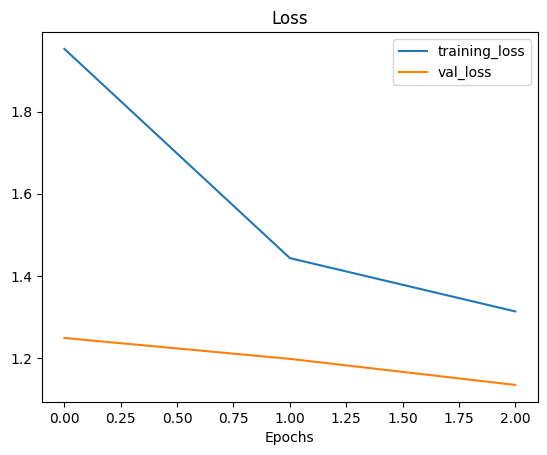

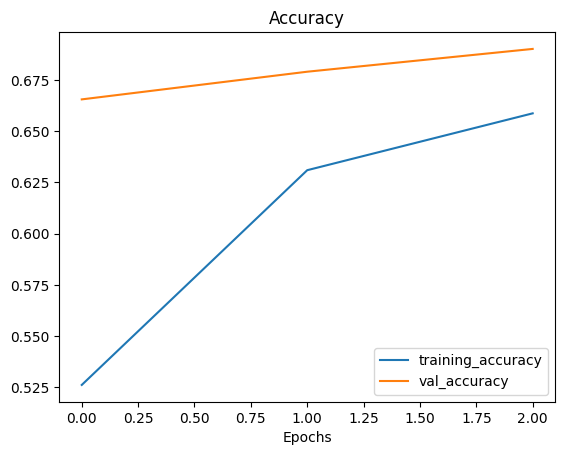

In [ ]:
plot_loss_curves(History)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SoftMax_layer (Activation)           │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,442,840 (16.95 MB)

 Trainable params: 131,941 (515.39 KB)

 Non-trainable params: 4,047,011 (15.44 MB)

 Optimizer params: 263,888 (1.01 MB)

In [ ]:
# Unfreeze the last 3 layers
# base_model.trainable = True

for layer_number,layer in enumerate(model.layers[1].layers):
  layer.trainable = True

for layer_number,layer in enumerate(model.layers[1].layers[:-3]):
  # print(layer.name,layer.trainable)
  layer.trainable = False
for layer_number,layer in enumerate(model.layers[1].layers[-10:]):
  print(layer.name,layer.trainable)



block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv False
block7a_project_bn False
top_conv True
top_bn True
top_activation True


In [ ]:
# Recompile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'],
              optimizer = tf.keras.optimizers.Adam())

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SoftMax_layer (Activation)           │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 541,541 (2.07 MB)

 Non-trainable params: 3,637,411 (13.88 MB)

In [ ]:
# run = wandb.init(
#     project = 'Fine Tuning Food101 Vision',
#     config = configs
# )

# Fit the model
History2 = model.fit(train_data,
                    epochs =configs['epochs'],
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)) #,
                    # callbacks = [WandbMetricsLogger(log_freq =10)]
                    )
# run.finish()

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 72s 22ms/step - accuracy: 0.6418 - loss: 1.3649 - val_accuracy: 0.7034 - val_loss: 1.0933
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.7045 - loss: 1.0898 - val_accuracy: 0.7142 - val_loss: 1.0740
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.7408 - loss: 0.9455 - val_accuracy: 0.7233 - val_loss: 1.0163


In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7152 - loss: 1.0387


[1.0326383113861084, 0.7184158563613892]

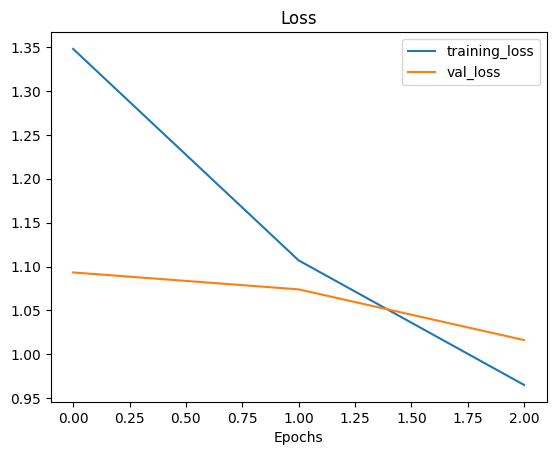

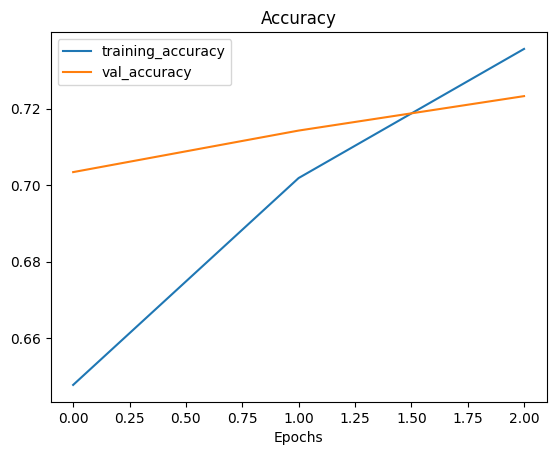

In [ ]:
plot_loss_curves(History2)

In [ ]:
# Unfreeze the last 4 layers
base_model.trainable = True

for layer_number,layer in enumerate(model.layers[1].layers):
  layer.trainable = True

for layer_number,layer in enumerate(model.layers[1].layers[:-4]):
  layer.trainable = False


for layer_number,layer in enumerate(model.layers[1].layers[-10:]):
  print(layer.name,layer.trainable)



block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv False
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [ ]:
# Recompile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'],
              optimizer = tf.keras.optimizers.Adam())

In [ ]:
# run = wandb.init(
#     project = 'Fine Tuning Food101 Vision',
#     config = configs
# )

# Fit the model
History3 = model.fit(train_data,
                    epochs =configs['epochs'],
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)) #,
                    # callbacks = [WandbMetricsLogger(log_freq = 10)]
                    )
# run.finish()

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step - accuracy: 0.7640 - loss: 0.8520 - val_accuracy: 0.7177 - val_loss: 1.0388
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7919 - loss: 0.7376 - val_accuracy: 0.7243 - val_loss: 1.0329
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8181 - loss: 0.6498 - val_accuracy: 0.7222 - val_loss: 1.0451


In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7268 - loss: 1.0507


[1.0469845533370972, 0.7253465056419373]

In [ ]:
# Unfreeze the last 5 layers
# base_model.trainable = True

for layer_number,layer in enumerate(model.layers[1].layers):
  layer.trainable =True

for layer_number,layer in enumerate(model.layers[1].layers[:-5]):
  layer.trainable = False



for layer_number,layer in enumerate(model.layers[1].layers[-10:]):
  print(layer.name,layer.trainable)



block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [ ]:
# Recompile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'],
              optimizer = tf.keras.optimizers.Adam())

In [ ]:
# run = wandb.init(
#     project = 'Fine Tuning Food101 Vision',
#     config = configs
# )

# Fit the model
History4 = model.fit(train_data,
                    epochs =3,
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)) #,
                    # callbacks = [WandbMetricsLogger(log_freq =10)]
                    )
# run.finish()

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - accuracy: 0.7775 - loss: 0.7657 - val_accuracy: 0.7121 - val_loss: 1.1107
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8207 - loss: 0.6201 - val_accuracy: 0.7243 - val_loss: 1.0772
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8464 - loss: 0.5292 - val_accuracy: 0.7185 - val_loss: 1.0751


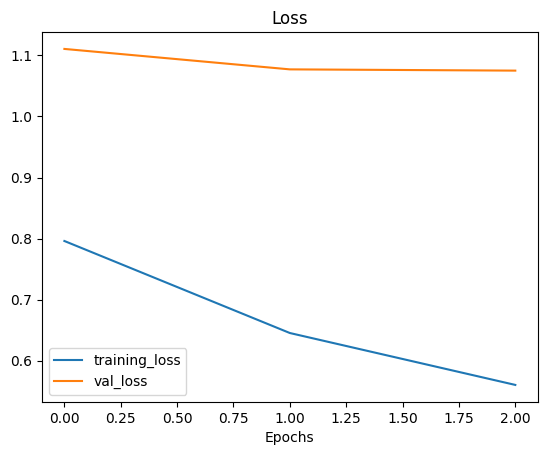

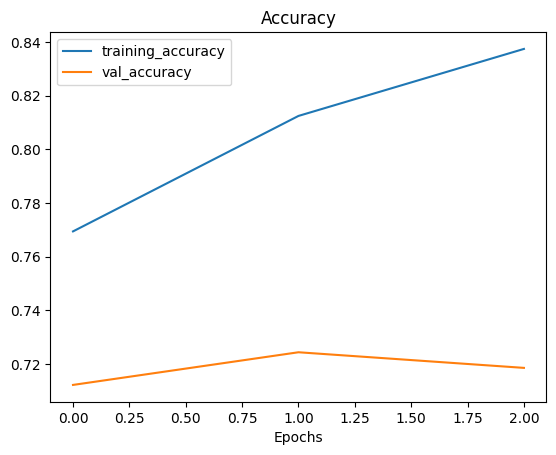

In [ ]:
plot_loss_curves(History4)

To get the weights and biases visuals [..link](https://wandb.ai/bushman254/Fine%20Tuning%20Food101%20Vision/reports/Fine-tuning-model--Vmlldzo5MzM0NTIw?accessToken=es05j8qp6zedts0mswa5ncqrra8l4y472dtyt3d6sn11qdsu6us1s15lz6f878dc)

A hunch their is overfitting in our model we should plot the loss curves to get a better view of the model with 5 layers unfrozen.
From the plot loss curves it can be observed that the curves tend to move away from each other indicating overfitting present in our data.

In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7337 - loss: 0.9827


[0.9764928817749023, 0.7348911166191101]

## Data Augmentation


In [ ]:
# Add Data Augmentation on the data as a layer (has benefits while using GPU)
IMG_SIZE = (224,224)
data_augmentation = keras.Sequential([
    layers.Input(shape = IMG_SIZE +(3,)),
    layers.RandomFlip('horizontal'),
    # layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomHeight(0.2),
    # layers.RandomWidth(0.2)
],name = 'data_augmentation')

In [ ]:
# Recreate the base model using data Augmentation
inputs =layers.Input(shape = IMG_SIZE + (3,),
                     name = 'Input_layer')
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
# base_model.trainable = False
for layer_number,layer in enumerate(base_model.layers[:-5]):
  layer.trainable = False # Since we are working with Fine-tuning
x =data_augmentation(inputs)

x = base_model(x)

x=layers.GlobalAveragePooling2D(name ='Global_averaging_pooling_layer')(x)

x= layers.Dense(len(class_names)) (x)
# To make sure the outputs tensors are in float 32 for numerical stability
outputs = layers.Activation('softmax',dtype = tf.float32,name = "Soft_max_layer")(x)
model =keras.Model(inputs,outputs)

# Compile model
model.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer =tf.keras.optimizers.Adam(learning_rate = 0.001))


In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Global_averaging_pooling_layer       │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Soft_max_layer (Activation)          │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 910,821 (3.47 MB)

 Non-trainable params: 3,268,131 (12.47 MB)

In [ ]:
# run = wandb.init(
#     project = 'Fine Tuning Food101 Vision',
#     config = configs
# )

# Fit the model
History5= model.fit(train_data,
                    epochs =3,
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)) #,
                    # callbacks = [WandbMetricsLogger(log_freq =10)]
                    )
# run.finish()

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 126s 48ms/step - accuracy: 0.4670 - loss: 2.1929 - val_accuracy: 0.6886 - val_loss: 1.1532
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 112s 47ms/step - accuracy: 0.6348 - loss: 1.3906 - val_accuracy: 0.7050 - val_loss: 1.0871
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 112s 47ms/step - accuracy: 0.6792 - loss: 1.2036 - val_accuracy: 0.7240 - val_loss: 0.9949


In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.7237 - loss: 1.0237


[1.0133352279663086, 0.7262178063392639]

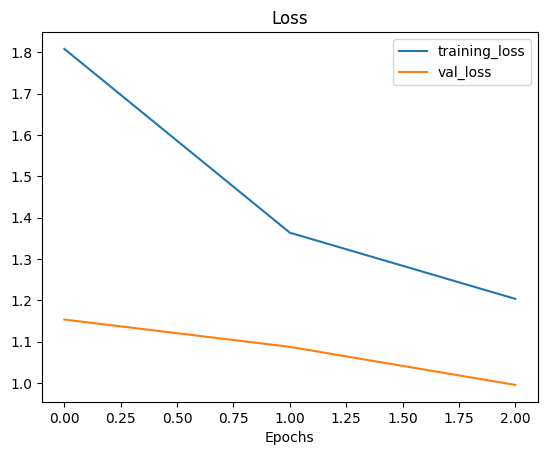

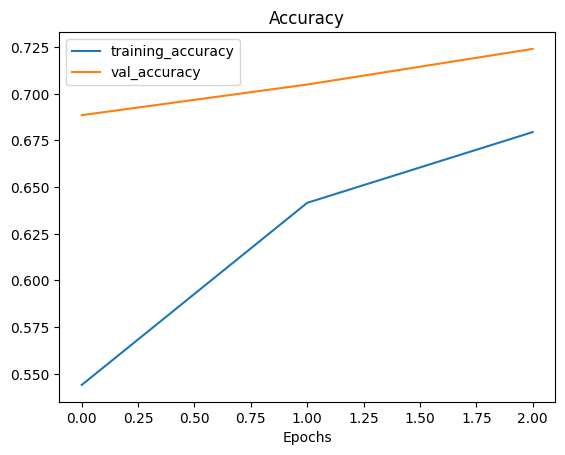

In [ ]:
plot_loss_curves(History5)

## Increase the number of epochs

In [ ]:
run = wandb.init(
    project = 'Fine Tuning Food101 Vision',
    config = configs
)

# Fit the model
History6= model.fit(train_data,
                    epochs =3,
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)),
                    callbacks = [WandbMetricsLogger(log_freq =10)]
                    )
run.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 113s 47ms/step - accuracy: 0.7072 - loss: 1.0809 - val_accuracy: 0.7428 - val_loss: 0.9603
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 113s 47ms/step - accuracy: 0.7311 - loss: 0.9873 - val_accuracy: 0.7248 - val_loss: 1.0013
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 113s 47ms/step - accuracy: 0.7541 - loss: 0.8827 - val_accuracy: 0.7312 - val_loss: 0.9452


batch/accuracy,▁▁▂▁▂▁▁▂▁▁▁▁▁▁▃▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▆▇▇██▇▇▇▇▇
batch/batch_step,▁▁▁▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇▇▇▇▇▇▇▇▇████▅▅▅▅▅▄▄▄▄▅▅▅▅▅▁▁▁▁▁▂▂▂▂▂
epoch/accuracy,▁▅█
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▄▁
epoch/val_accuracy,█▁▃
epoch/val_loss,▃█▁
batch/accuracy,0.75011


In [ ]:
run = wandb.init(
    project = 'Fine Tuning Food101 Vision',
    config = configs
)

# Fit the model
History7= model.fit(train_data,
                    epochs =4,
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)),
                    callbacks = [WandbMetricsLogger(log_freq =10)]
                    )
run.finish()

wandb: Currently logged in as: savins (bushman254). Use `wandb login --relogin` to force relogin


Epoch 1/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 113s 48ms/step - accuracy: 0.7691 - loss: 0.8253 - val_accuracy: 0.7415 - val_loss: 0.9806
Epoch 2/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 115s 48ms/step - accuracy: 0.7803 - loss: 0.7683 - val_accuracy: 0.7394 - val_loss: 0.9970
Epoch 3/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 114s 48ms/step - accuracy: 0.8046 - loss: 0.6863 - val_accuracy: 0.7328 - val_loss: 1.0054
Epoch 4/4
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 114s 48ms/step - accuracy: 0.8141 - loss: 0.6457 - val_accuracy: 0.7476 - val_loss: 0.9833


batch/accuracy,▂▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▇▇▇▇▆▆▆▇████████▇▇▇▇
batch/batch_step,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▆▆▆▅▆▆▆▆▆▆█▅▄▄▄▄▄▄▅▅▂▂▂▂▃▃▃▃▃▃▂▂▁▁▁▁▁▂▂▂
epoch/accuracy,▁▃▆█
epoch/epoch,▁▃▆█
epoch/learning_rate,▁▁▁▁
epoch/loss,█▆▃▁
epoch/val_accuracy,▅▄▁█
epoch/val_loss,▁▆█▂
batch/accuracy,0.8085


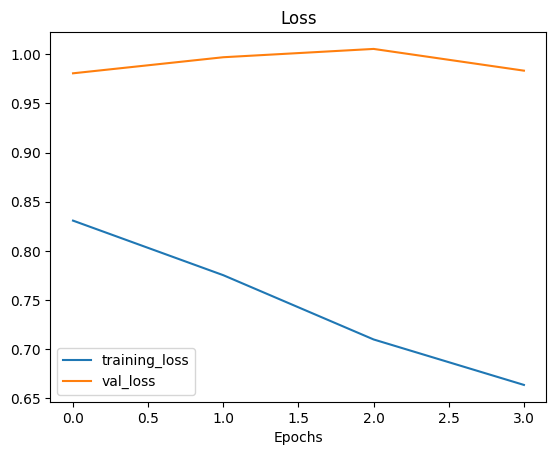

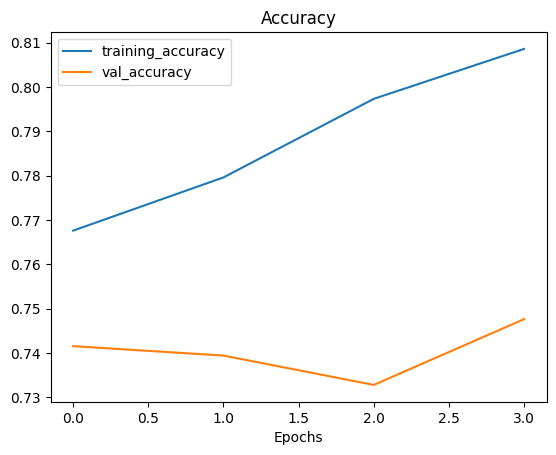

In [ ]:
plot_loss_curves(History7)

In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7380 - loss: 1.0125


[1.0030077695846558, 0.7403564453125]

In [ ]:
run = wandb.init(
    project = 'Fine Tuning Food101 Vision',
    config = configs
)

# Fit the model
History8= model.fit(train_data,
                    epochs =5,
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)),
                    callbacks = [WandbMetricsLogger(log_freq =10)]
                    )
run.finish()

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 114s 48ms/step - accuracy: 0.8318 - loss: 0.5900 - val_accuracy: 0.7479 - val_loss: 1.0180
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 114s 48ms/step - accuracy: 0.8409 - loss: 0.5477 - val_accuracy: 0.7346 - val_loss: 1.0290
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 143s 48ms/step - accuracy: 0.8492 - loss: 0.5189 - val_accuracy: 0.7331 - val_loss: 1.0297
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 114s 48ms/step - accuracy: 0.8580 - loss: 0.4808 - val_accuracy: 0.7338 - val_loss: 1.0840
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 114s 48ms/step - accuracy: 0.8641 - loss: 0.4531 - val_accuracy: 0.7489 - val_loss: 1.0840


batch/accuracy,▄▃▃▃▁▁▄▅▅▄▅▆▆▆▆▅▄▄▄▄▇▇▇▇▇▇▇▇▆▆▅▅▇▇▇███▇▇
batch/batch_step,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▇▆▆▆▇▇██▅▅▅▅▅▆▆▄▄▄▄▄▅▅▅▅▂▂▂▂▂▂▃▃▁▁▁▁▁▂▂▂
epoch/accuracy,▁▃▅▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▆▄▃▁
epoch/val_accuracy,█▂▁▁█
epoch/val_loss,▁▂▂██
batch/accuracy,0.8588


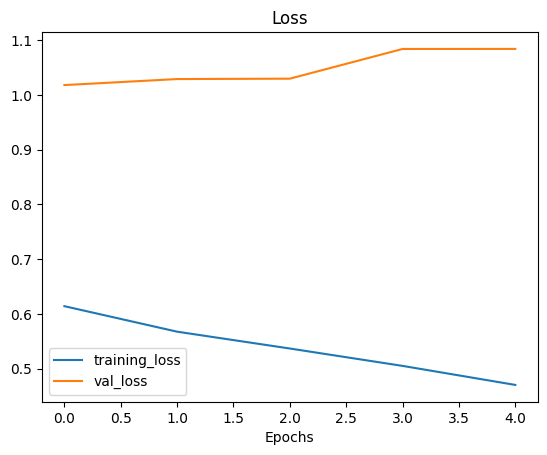

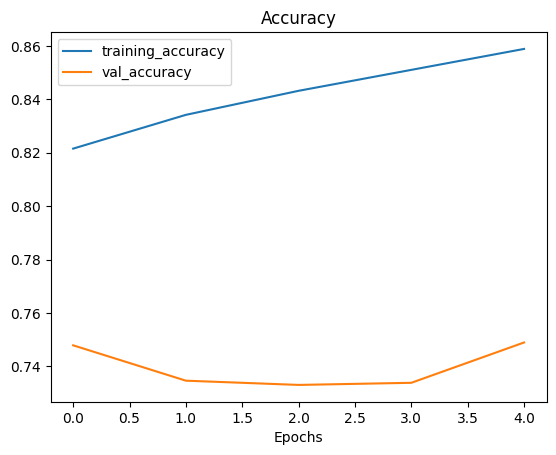

In [ ]:
plot_loss_curves(History8)


In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7350 - loss: 1.0914


[1.0857023000717163, 0.7371088862419128]

## Reduce the dataset

In [ ]:
run = wandb.init(
    project = 'Fine Tuning Food101 Vision',
    config = configs
)

# Fit the model
History8= model.fit(train_data.repeat(),
                    epochs =5,
                    steps_per_epoch = int(0.5*len(train_data)),
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)),
                    callbacks = [WandbMetricsLogger(log_freq =10)]
                    )
run.finish()

Epoch 1/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 60s 50ms/step - accuracy: 0.8705 - loss: 0.4354 - val_accuracy: 0.7405 - val_loss: 1.0919
Epoch 2/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.8595 - loss: 0.4665 - val_accuracy: 0.7346 - val_loss: 1.0847
Epoch 3/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 59s 49ms/step - accuracy: 0.8824 - loss: 0.3987 - val_accuracy: 0.7370 - val_loss: 1.0976
Epoch 4/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 59s 49ms/step - accuracy: 0.8688 - loss: 0.4457 - val_accuracy: 0.7402 - val_loss: 1.0885
Epoch 5/5
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.8858 - loss: 0.3825 - val_accuracy: 0.7413 - val_loss: 1.1136


batch/accuracy,▁▃▄▅▅▅▁▁▁▁▁▁▂▂▂▇▇▇▇▇▇▇▄▄▃▄▄▄▄▄▄▆▆███████
batch/batch_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇██████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▄▄▃▃▃▃▅▅▆▆▆▆▆▆▄▂▂▂▂▂▅▅▅▅▄▄▄▄▄▄▁▁▁▁▁▁▁
epoch/accuracy,▅▁▇▃█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,▄█▂▆▁
epoch/val_accuracy,▇▁▄▇█
epoch/val_loss,▃▁▄▂█
batch/accuracy,0.88802


In [ ]:
run = wandb.init(
    project = 'Fine Tuning Food101 Vision',
    config = configs
)

# Fit the model
History8= model.fit(train_data.repeat(),
                    epochs =5,
                    steps_per_epoch = int(0.4*len(train_data)),
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)),
                    callbacks = [WandbMetricsLogger(log_freq =10)]
                    )
run.finish()

Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 63s 54ms/step - accuracy: 0.3363 - loss: 2.8270 - val_accuracy: 0.6155 - val_loss: 1.4327
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.5188 - loss: 1.9056 - val_accuracy: 0.6480 - val_loss: 1.3203
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.5526 - loss: 1.7358 - val_accuracy: 0.6684 - val_loss: 1.2168
Epoch 4/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.5932 - loss: 1.5824 - val_accuracy: 0.6796 - val_loss: 1.1900
Epoch 5/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.5903 - loss: 1.5856 - val_accuracy: 0.6923 - val_loss: 1.1282


batch/accuracy,▁▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▁▁
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▂▁
batch/accuracy,0.59478


## Find Ideal learning Rate


In [ ]:

#Create a learning_rate callback
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-4*(10**(epoch/2)))

# Fit the model
History8= model.fit(train_data.repeat(),
                    epochs =5,
                    steps_per_epoch = int(0.6*len(train_data)),
                    validation_data = test_data.repeat(),
                    validation_steps = int(0.15*len(test_data)),
                    callbacks = [lr_scheduler]
                    )


Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.1929 - loss: 3.8275 - val_accuracy: 0.5347 - val_loss: 1.9063 - learning_rate: 1.0000e-04
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.4799 - loss: 2.1545 - val_accuracy: 0.6417 - val_loss: 1.3684 - learning_rate: 3.1623e-04
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 49s 51ms/step - accuracy: 0.5360 - loss: 1.8196 - val_accuracy: 0.6454 - val_loss: 1.2761 - learning_rate: 0.0010
Epoch 4/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 49s 51ms/step - accuracy: 0.5200 - loss: 1.8838 - val_accuracy: 0.6496 - val_loss: 1.3142 - learning_rate: 0.0032
Epoch 5/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.4617 - loss: 2.2118 - val_accuracy: 0.6147 - val_loss: 1.5693 - learning_rate: 0.0100


Text(0.5, 0, 'Learning rate')

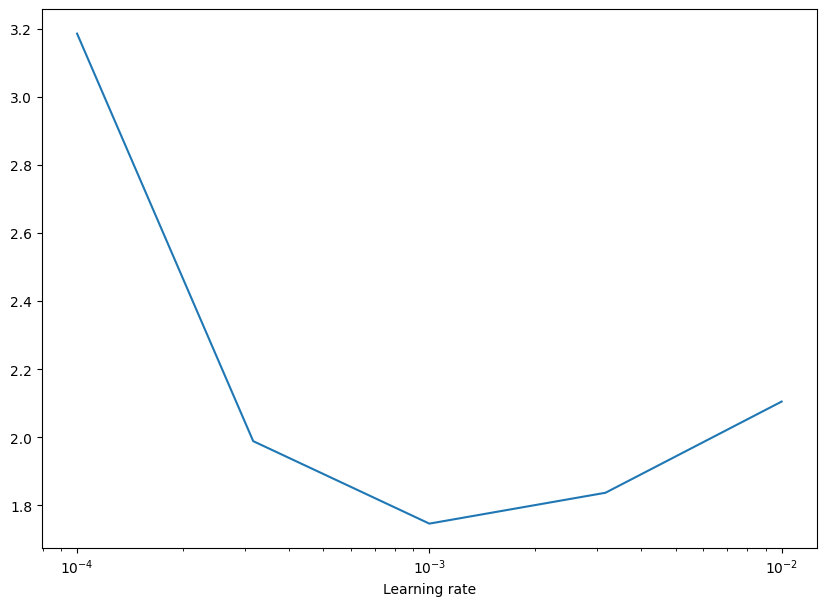

In [ ]:
lrs=1e-4*(10**(tf.range(5)/2))
lrs
plt.figure(figsize=(10,7))
plt.semilogx(lrs,History8.history["loss"])
plt.xlabel("Learning rate")

The learning rate appears to be just fine

In [ ]:
len(test_data)

790

In [ ]:
y_pred=Prob_pred.argmax(axis =1 )

In [ ]:
y_pred.shape

(25250,)

In [ ]:
from Functions import make_confusion_matrix

In [ ]:
# make_confusion_matrix(test_data,y_pred,classes = class_names)

ValueError: Found input variables with inconsistent numbers of samples: [790, 25250]